## Assignment 3 Stereo Matching
## Nitin Kandpal, Roll number : 2018802004

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('Stereo_Images/Stereo_Pair1.jpg')
gray= cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)
[h,w] = gray.shape

gray1 = gray[:,0:round(w/2)]
gray2 = gray[:,round(w/2):w]

In [3]:
def dense_shift(gray1,gray2, step_size):
    sift = cv2.xfeatures2d.SIFT_create()
        # find the keypoints and descriptors with SIFT       
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray1.shape[0], step_size) 
                                        for x in range(0, gray1.shape[1], step_size)]
    kp1,des1 = sift.compute(gray1,kp)
    kp2,des2 = sift.compute(gray2,kp)
    
    return kp1,des1,kp2,des2

In [4]:
def dense_sift_matching(gray1,gray2):
    kp1,des1,kp2,des2 = dense_shift(gray1,gray2, 20)
    #out1 = cv2.drawKeypoints(gray2,kp2,None)
    #plt.imshow(out1),plt.show()
    
    # Match descriptors.
    bf = cv2.BFMatcher()
    matches = bf.match(des1,des2)

 # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

 # Draw first 10 matches.
    out = cv2.drawMatches(gray1,kp1,gray2,kp2,matches ,None, flags=2)
    fig=plt.figure(figsize=(16, 16))
    plt.imshow(out),plt.show()

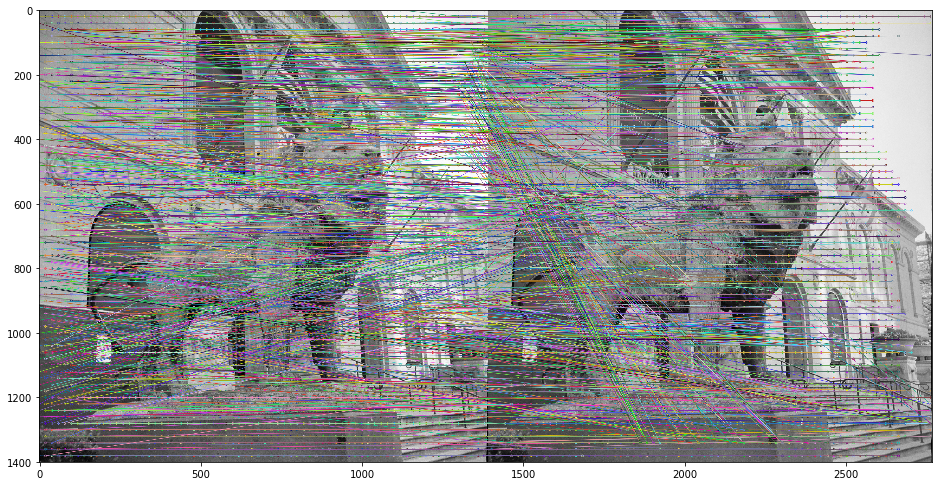

In [5]:
dense_sift_matching(gray1,gray2)

### Intensity based correlation method
### we are only using each 10 th pixles of image1 as feature and seraching it to 20 x20 area of second image with 5x5 template matching size. It will be 15x15 search for each feature.   

In [6]:
def intensity_correlation(gray1,gray2,rectified,debug):
    
    [h,w] = gray1.shape
    matches = []
    for row in range(10,h-10,30):
        for col in range(10,w-10,30):
            
            ## fixed the collumn
            if (debug):
                col = 540
            key = [row,col]
            
            template = gray1[row-1:row+2,col-1:col+2]
            #print(template.shape)
            if(rectified):
                window = gray2[row-1:row+2,col-10:col+10]
                res = cv2.matchTemplate(window,template,eval('cv2.TM_CCORR_NORMED'))
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

                row2 = max_loc[1] + row 
                col2 = max_loc[0] + col-9                
            else:
                window = gray2[row-10:row+10,col-10:col+10] 
                res = cv2.matchTemplate(window,template,eval('cv2.TM_CCORR_NORMED'))
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

                row2 = max_loc[1] + row -9
                col2 = max_loc[0] + col-9

            matches.append([row,col,row2,col2])
    return matches

In [7]:
    # Apply template Matching
    #res = cv.matchTemplate(img,template,method)
    #min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

In [8]:
import random
def draw_window_match(gray,window_matches):
    
    [h,w] = gray.shape
    gray_d = gray.copy()
    gray_d= cv2.cvtColor(gray_d ,cv2.COLOR_GRAY2BGR)
    for match in window_matches:
        
        cv2.line(gray_d,(int(match[1]),int(match[0])),(int(round(match[3] + w/2)),int(match[2])),(random.randint(0,255),random.randint(0,255),random.randint(0,255)),2)
        #print(match) 
    fig=plt.figure(figsize=(16, 16))
    plt.imshow(gray_d,cmap='gray'),plt.show()

### just to deubug and show result of matching only one clumn pixel

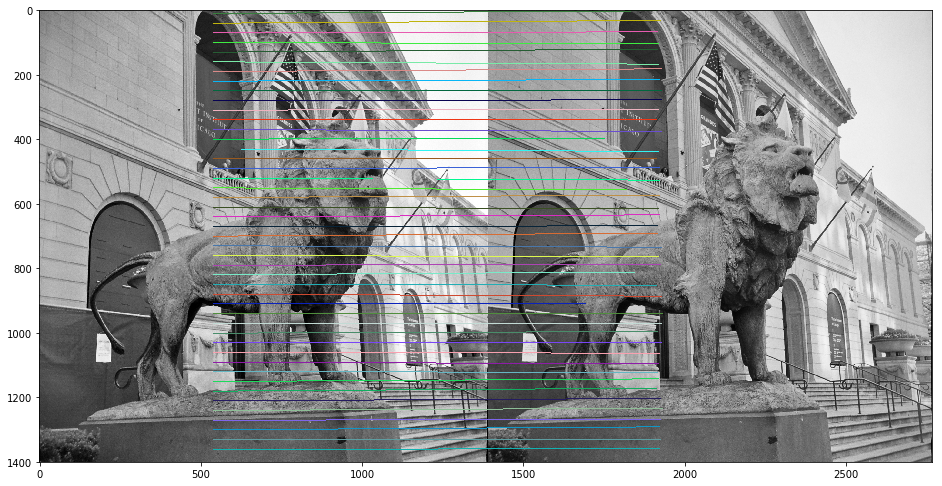

In [9]:

window_matches_debug = intensity_correlation(gray1,gray2,False,True)
draw_window_match(gray,window_matches_debug)



### full feature matching of 20 by 20 grid window method

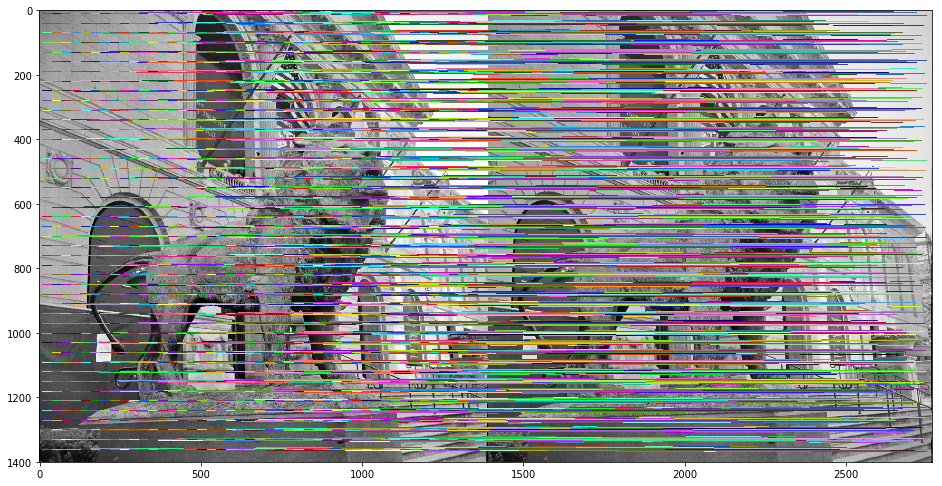

In [10]:

window_matches = intensity_correlation(gray1,gray2,False,False)
draw_window_match(gray,window_matches)

As there are no epipolar constarined window matching is very poor technique to find correspondance point and it is time consuming. 
In case shift looks better as it select the keyfeature points and perform the matching but its limited only for keypoint features. 

### Function to calculate fundamental matrix


In [11]:
def point1_point2_matrix(img_point1, img_point2):
    
    xl1 = img_point1[0,0]
    xr1 = img_point2[0,0]
    yl1 = img_point1[0,1]
    yr1 = img_point2[0,1]
    
    pointX = [xr1*xl1, xr1*yl1, xr1, yr1*xl1, yr1*yl1, yr1,
              xl1,yl1,1]
    return pointX

def calculate_fundamental_matrix(img1_points,img2_points):
    #M = np.empty((2*img_points.shape[0], 12),dtype='int64')
    A = []
    count = 0
    for img1_point,img2_point in zip(img1_points,img2_points):
        pointX = point1_point2_matrix(img1_point,img2_point)
        #print(pointX,pointY)
        ## 2x9 matr
        #np.append(M,np.array(A_point),axis=0)
        A.append(pointX)
       
    A = np.array(A)
    ### perfomr SVD
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    #print(u.shape,s.shape,vh.shape)
    ## use the last value
    M = np.transpose(vh)
    M_1d = M[:,-1]
    M_1d = M_1d/M_1d[-1]
    M_2d = np.reshape(M_1d,[3,3])

    # correctness of fundamnetal matrix
    u1,s1,vh1 = np.linalg.svd(M_2d, full_matrices=True)
        
    s2 = np.diag(s1)
    
    s2[2,2] = 0
    
    #print(u1.shape,s2.shape,vh1.shape)
    
    F = np.dot(np.dot(u1,s2),vh1)
    F = F/F[2,2]
    
    return F



### Image rectification 

In [12]:
def image_rectification(img1,img2):

    #img2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

    #img1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)

    #find the shift point

    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)


    ## match the points 
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)


    # select the good points
    selected_match = []
    number_of_good_point=0
    for match in matches:
        if match[0].distance < 0.5*match[1].distance:
            selected_match.append(match)
            number_of_good_point = number_of_good_point+1
    matches = np.asarray(selected_match)
        #if len(matches[:,0]) >= 4:
    ## check if number of good matched points are greater or equal to 4    
    if number_of_good_point >= 9:
        src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        ## calculate the homography    
        
        #F = calculate_fundamental_matrix(src,dst) 
        F, mask = cv2.findFundamentalMat(src,dst,cv2.FM_LMEDS)
        
        ret,H1,H2 = cv2.stereoRectifyUncalibrated(src,dst,F,(img1.shape[1],img1.shape[0]))
        ## perform the image warping 
        # warp the image1 in with homograply 
        inv_H1 = np.linalg.inv(H1)
        rect_img1 = cv2.warpPerspective(img1,H1,(img1.shape[1],img1.shape[0]))
        rect_img2 = cv2.warpPerspective(img2,H2,(img2.shape[1],img2.shape[0]))
        
        return rect_img1,rect_img2
    else:
        print ("no proper matches found")
        return None

In [13]:
rect_gray1,rect_gray2 = image_rectification(gray1,gray2)

In [14]:
#rect_gray1

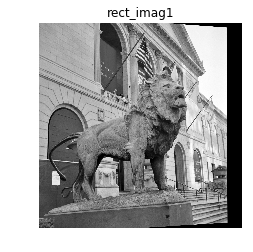

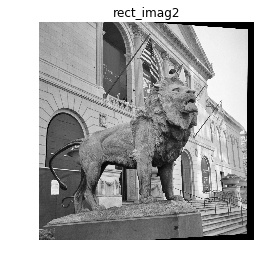

(<matplotlib.image.AxesImage at 0x7f5ff1bc8828>, None)

In [15]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.axis("off")
plt.title("rect_imag1")
plt.imshow(rect_gray1,cmap='gray'),plt.show()
fig.add_subplot(rows, columns, 2)
plt.axis("off")
plt.title("rect_imag2")
plt.imshow(rect_gray2,cmap='gray'),plt.show()

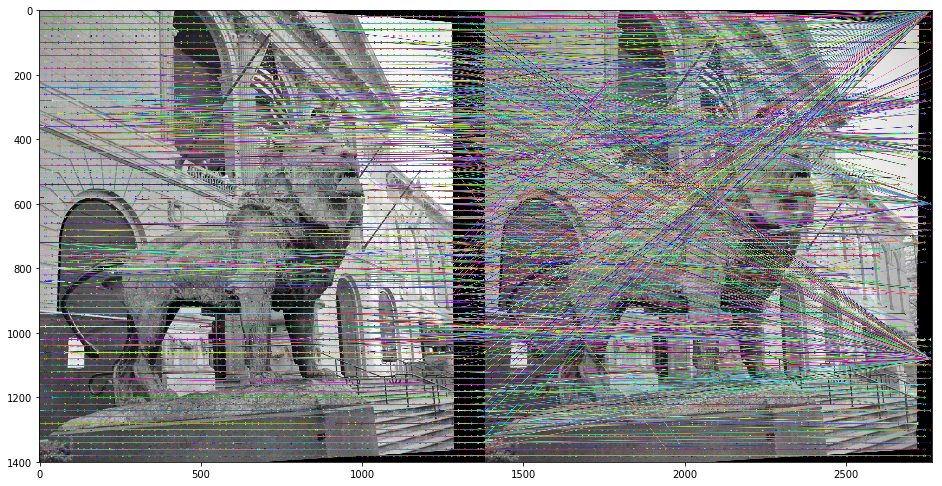

In [16]:
dense_sift_matching(rect_gray1,rect_gray2)

now wee need to search one column (line) to find the correspondance point as our images is rectified

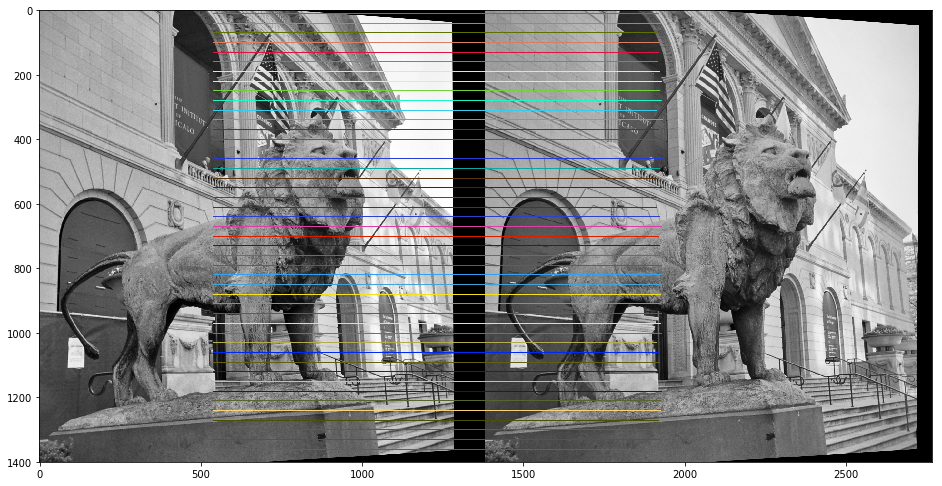

In [17]:
window_matches = intensity_correlation(rect_gray1,rect_gray2,True,True)

#print(window_matches)

rect_gray = np.concatenate((rect_gray1,rect_gray2),axis=1)
draw_window_match(rect_gray,window_matches)

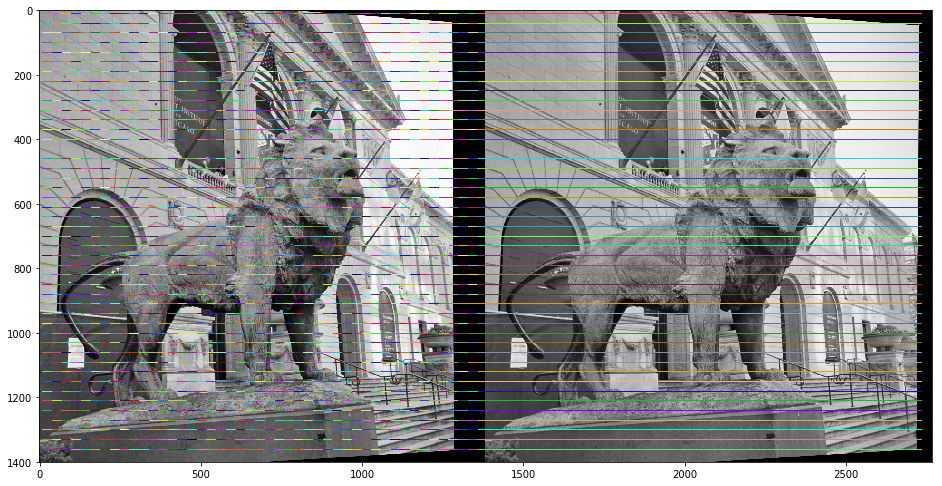

In [18]:
window_matches = intensity_correlation(rect_gray1,rect_gray2,True,False)

#print(window_matches)

rect_gray = np.concatenate((rect_gray1,rect_gray2),axis=1)
draw_window_match(rect_gray,window_matches)

In [19]:
## create_row_feature_list it will be only work for rectified images 

In [20]:
def create_row_feature_list(img1,img2):

    #img2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

    #img1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)

    #find the shift point

    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    
    [h,w] = img1.shape
    
    A1 = {}
    A2 = {}
    for row in range(0,h):
        
        temp_list1 = []
        temp_list2 = []
        for keypoint1 in kp1: 
        ## if keypoint in row
            if (row == round(keypoint1.pt[1])):
                temp_list1.append(keypoint1.pt[0])
             
        A1[str(row)]= temp_list1
    
        for keypoint2 in kp2: 
        ## if keypoint in row
            
            if (row == round(keypoint2.pt[1])):
                temp_list2.append(keypoint2.pt[0])
            
        A2[str(row)]=temp_list2   
    return A1,A2
    

In [21]:
A1,A2 = create_row_feature_list(rect_gray1,rect_gray2)

In [22]:
A1['3']

[553.8052368164062, 734.1897583007812, 804.4258422851562]

### DTW  matching 

In [23]:
def DTW (y,x):
    D = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            D[i,j] = (x[j]-y[i])**2 
    
    
    accumulated_cost = np.zeros((len(y), len(x)))
    accumulated_cost[0,0] = D[0,0]
    for i in range(1, len(y)):
        accumulated_cost[i,0] = D[i, 0] + accumulated_cost[i-1, 0]
    for i in range(1, len(x)):
        accumulated_cost[0,i] = D[0,i] + accumulated_cost[0, i-1] 
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + D[i, j]

    def path_cost(x, y, accumulated_cost, distances):
        path = [[len(x)-1, len(y)-1]]
        cost = 0
        i = len(y)-1
        j = len(x)-1
        while i>0 and j>0:
            if i==0:
                j = j - 1
            elif j==0:
                i = i - 1
            else:
                if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                    i = i - 1
                elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                    j = j-1
                else:
                    i = i - 1
                    j= j- 1
            path.append([j, i])
        path.append([0,0])
        for [y, x] in path:
            cost = cost +distances[x, y]
        return path, cost    
    path, cost = path_cost(x, y, accumulated_cost, D)
    
    return path,cost

In [24]:
## DTW 

for key in range(0,10):
    
    #chek if both row have features in both images
    if (A1[str(key)] != []) & (A2[str(key)] != []):
        
        row_feature1 = A1[str(key)]
        row_feature2 = A2[str(key)]
        
        print("row number" , key)
        print("number_of_feature" ,len(row_feature1),len(row_feature1))

        
        
        
        #print (path,cost)
        

        paths,cost = DTW(row_feature2,row_feature1)
        print("map of columns with img1 and img2 ", paths,"cost",cost)

row number 3
number_of_feature 3 3
map of columns with img1 and img2  [[2, 5], [1, 5], [0, 4], [0, 0]] cost 24387.719198711216
row number 4
number_of_feature 4 4
map of columns with img1 and img2  [[3, 3], [2, 3], [1, 2], [1, 1], [0, 0], [0, 0]] cost 98605.1785190925
row number 5
number_of_feature 5 5
map of columns with img1 and img2  [[4, 3], [3, 2], [3, 1], [2, 0], [0, 0]] cost 75597.3455270771
row number 6
number_of_feature 5 5
map of columns with img1 and img2  [[4, 8], [3, 7], [2, 6], [2, 5], [2, 4], [2, 3], [1, 2], [1, 1], [0, 0], [0, 0]] cost 231112.20303480886
row number 7
number_of_feature 10 10
map of columns with img1 and img2  [[9, 3], [8, 3], [7, 3], [6, 3], [5, 3], [4, 3], [3, 2], [2, 2], [1, 1], [0, 0], [0, 0]] cost 596979.2603057036
row number 8
number_of_feature 4 4
map of columns with img1 and img2  [[3, 5], [2, 4], [2, 3], [2, 2], [1, 1], [0, 0], [0, 0]] cost 145619.52418781817
row number 9
number_of_feature 3 3
map of columns with img1 and img2  [[2, 2], [1, 1], [0

In [25]:
## above show the matching of point 